In [ ]:
%matplotlib inline

import os
import sys
from itertools import product
import numpy as np
np.set_printoptions(precision=4,suppress=True, linewidth=140)
import scipy

import matplotlib.pyplot as plt

from h5 import HDFArchive
from triqs.gf import *
from triqs.gf.descriptors import Fourier, Omega
from triqs.plot.mpl_interface import plt,oplot
from triqs.lattice.utils import TB_from_wannier90, k_space_path

import solid_dmft.postprocessing.plot_correlated_bands as pcb
import solid_dmft.postprocessing.maxent_sigma as sigma_maxent

# TRIQS / solid_dmft tutorial 

La2CuO4 is one of the high Tc superconductors and can be relatively well described by a 2D Hubbard model on a square lattice which connects the Cu ions. Further below, we will discuss why this material is well suited for DMFT and that the mapping to a low-energy description is straightforward. For a theoretical overview over DFT+DMFT you may be interested in this paper [doi.org/10.1103/PhysRevB.91.125142](https://doi.org/10.1103/PhysRevB.91.125142). 

This tutorial should give you an introduction to DMFT calculations. It will introduce the important observables / results that are obtained, and how to understand them. Furthermore, you will learn the basic workflows of using TRIQS as a library.

During the tutorial we marked specific tasks (look out for **TASK**) that we recommend you do to deepen your understanding of DMFT, the Green's function formalism, and the usage of TRIQS. All tasks can be done directly in this jupyter notebook.

more information about the DFT+DMFT formalism and the utilized codes can be found here: 
* DFT+DMFT implementation using Quantum Espresso + Wannier90 + TRIQS: [doi.org/10.1088/1361-648X/ac5d1c](https://doi.org/10.1088/1361-648X/ac5d1c)
* TRIQS documentation: [triqs.github.io](https://triqs.github.io/triqs/latest)
* solid_dmft documentation: [flatironinstitute.github.io/solid_dmft](https://flatironinstitute.github.io/solid_dmft)
* solid_dmft input parameter reference: [flatironinstitute.github.io/solid_dmft/_autosummary/read_config](https://flatironinstitute.github.io/solid_dmft/_autosummary/read_config.html)
* more TRIQS tutorials: [github.com/TRIQS/tutorials](https://github.com/TRIQS/tutorials/tree/3.0.x/TRIQSTutorialsPython)

---
__IMPORTANT__: please make sure to run first the following command in the shell within the VM: 
```
source triqs_activate.sh 
```

Running jupyter-lab will open a port 8888 that can be accessed via the VM web GUI or via port forwarding. FermiSee (to be used later) will be available on port 8889. To forward the port via your ssh connection, connect via ssh specifying the following extra options:

```
ssh your@mail.com@ins45124.ictp.it -L 7899:localhost:8888 -L 7898:localhost:8889
```

After you start either jupyter-lab or FermiSee you can access them by typing the following address in your local browser: 127.0.0.1:7899 (jupyter) or 127.0.0.1:7898 (FermiSee).
For accessing jupyter you also need the token that jupyter-lab prints in the terminal after execution.

---

## 0. Performing a DFT Quantum Espresso calculation and create a Wannier Hamiltonian

(This step is a recap of running DFT and creating Wannier function. Due to the lack of time we provide all the output here, but feel free to repeat the steps.)

The aim is to perform a SCF DFT calculation with Quantum Espresso (QE), identify a correlated subspace (here: Cu $d_{x^2-y^2}$ orbital), and create a Wannier Hamiltonian for this orbital. The results will be converted to a TRIQS readable h5 format, via the [triqs.github.io/dft_tools](https://triqs.github.io/dft_tools/latest/) package. The input for the QE SCF calculation can be found in the folder `QE/scf/lco.scf.in` , and consecutively a NSCF calculation has to be performed to obtain the input for Wannier90 (W90) `QE/mlwf`. We also perform a bandstructure calculation `QE/bands/lco.bnd.in` to compare our Wannier fit with the DFT bands. Last, we construct a Wannier Hamiltonian using W90 (`QE/mlwf`). In this specific case we construct one Wannier function for the Cu $d_{x^2-y^2}$ orbital with disentanglement. The input for W90 looks like (`QE/mlwf/lco.win`):

The W90 input contains the following important parameters:

```
num_wann = 1
num_bands = 2
mp_grid 7 7 7

exclude_bands : 1-31,34-40

dis_win_min = 10.5
dis_win_max = 16.0
dis_froz_min = 12.3
dis_froz_max = 16.0
```

The latter is necessary to properly disentangle the target WF from the other bands. 

The bands in QE and W90 will be plotted along the following path (green line) in the BZ:

* G:  [ 0.00,  0.00,  0.00]
* S': [ 0.25, -0.25,  0.25]
* X:  [ 0.00,  0.00,  0.50]
* Z:  [ 0.25,  0.25, -0.25]

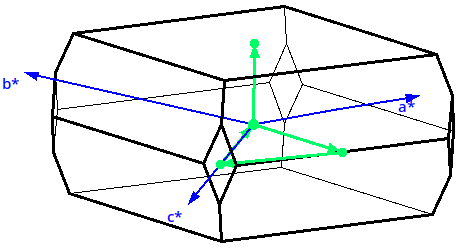


# 1. Creating a low-energy description of La$_2$CuO$_4$

In this section we will discuss the process of constructing a low-energy model of the material.

### DFT density of states

Let us first take a look at the density of states to identify the character of the states close to the Fermi level:

In [ ]:
# read partial DOS from QE
loc = './QE/scf/dos/'
seedname = 'lco'
fermi = 12.7367

dos_data = {}
elems = {'La': range(1,3), 'Cu': range(3,4), 'O': range(4,8)}
char_table = {'La': {1: 's', 2: 'p', 3: 'd', 4: 's', 5: 'p', 6: 'f'},
              'Cu': {1: 's', 2: 'p', 3: 'd', 4: 's', 5: 'p'},
              'O': {1: 's', 2: 'p'}}

with open(loc + f'{seedname}.pdos_tot', 'r') as f:
    dos_data['tot'] = np.loadtxt(f)

for ct, (el, n_atom) in enumerate(elems.items()):
    n_char = char_table[el].keys()
    for atom, char in product(n_atom, n_char):
        with open(loc + f'{seedname}.pdos_atm#{atom}({el})_wfc#{char}({char_table[el][char]})') as f:
            dos_data[f'{el}-{atom}-{char}{char_table[el][char]}'] = np.loadtxt(f)
            
# read the w90 DOS for comparison
with open('./QE/mlwf/lco-dos.dat', 'r') as f:
    w90_dos = np.loadtxt(f)

In [ ]:
fig, ax = plt.subplots(1, dpi=150, figsize=(8,3))

# plot total density of states
ax.fill_between(dos_data['tot'][:,0] - fermi, dos_data['tot'][:,1], zorder=2, color='gray', lw=0., alpha=0.3, label='total')

# plot partial DOS. The entry number corresponds to the orbital order in QE:
# 0 col is the energy, then the summed partial DOS, the columns are dz2, dxz, dyz, dx2-y2, dxy
Cu_dx2y2 = np.sum([dos_data[f'Cu-3-3d'][:,5]], axis=0)
ax.plot(dos_data['tot'][:,0] - fermi, Cu_dx2y2, label=r'Cu-$d_{x^2-y^2}$', zorder=10)

Cu_dz2 = np.sum([dos_data[f'Cu-3-3d'][:,2]], axis=0)
ax.plot(dos_data['tot'][:,0] - fermi, Cu_dz2, label=r'Cu-$d_{z^2}$')

O = np.sum([dos_data[f'O-{atom}-2p'][:,1] for atom in elems['O']], axis=0)
ax.plot(dos_data['tot'][:,0] - fermi, O, label=r'O-$p$')

# plot the w90 DOS
ax.plot(w90_dos[:,0]-fermi, w90_dos[:,1], label='w90 DOS')

ax.set_xlim(-8,2.8)
ax.set_ylim(0,4)
ax.set_ylabel('DOS')
ax.set_xlabel(r'$\omega$ (eV)')
ax.legend()
plt.show()

It can be observed that the states right at the Fermi level are dominantly of Cu $d_{x^2-y^2}$ (blue) character hybridized with O $p$ states (green). The W90 DOS matches exactly the total DOS in the window given by the Cu $d_{x^2-y^2}$ states, capturing the nature of the bonding orbitals as well. This means that this is the best compromise of having a localized Cu $d_{x^2-y^2}$-character-like state, but still describing properly the electronic states corresponding to the band close to the Fermi level.

__TASK__: What is the reason for the contributions to the DOS of the Cu $d_{x^2-y^2}$ (blue) states at low energies between -8 and -5 eV?

### Plot QE bands together with W90 bands to check quality of Wannier fit

To check more carefully whether the tight-binding Hamiltonian describes the DFT bands close to the Fermi level correctly, we now plot the QE and the W90 bands on top of each other. To plot the W90 bands we will make use of the solid_dmft postprocessing module [plot_correlated_bands](https://flatironinstitute.github.io/solid_dmft/_autosummary/postprocessing.html) (`pcb`). This utility reads the real space Wannier Hamiltonian, and then leverages Wannier interpolation to construct $H(k)$ on any given $k$ point mesh.

In [ ]:
# w90 information
w90_dict = {'w90_path': './QE/mlwf/',
            'w90_seed': 'lco',
            'add_spin': False, 'add_lambda': None,
            'n_orb': 1,
            'mu': fermi,
            'orbital_order_w90': [0]}

# plotting options
plot_dict = {'colorscheme_bands': 'coolwarm', 'proj_on_orb': None, 'vmin': 0.0}

# tight-binding-like bands we want to plot from the given W90 Hamiltonian
tb_bands = {'bands_path': [('G', 'S\''), ('S\'', 'X'), ('X', 'G'), ('G', 'Z')], 'n_k': 50,
            'G': [ 0.0,  0.0,  0.0], 'S\'': [0.25, -0.25, 0.25], 'X': [0.0,  0.0,  0.5 ], 'Z': [0.25,  0.25, -0.25] }

# get_dmft_bands extracts H(k) from the above specified path
tb_bands_data, alatt_k_w_path, freq_dict, dft_mu = pcb.get_dmft_bands(orbital_order_to = [0], **w90_dict, **tb_bands)

# also load the bands.dat.gnu file for a comparison
band_data = np.loadtxt('./QE/bands/lco_bands.dat.gnu') 

In [ ]:
fig, ax = plt.subplots(1,dpi=150,figsize=(5,6))

# since every code uses a different scale for a k-path we have to scale the QE bands
factor = tb_bands_data['k_mesh'][-1]/band_data[-1,0]

# plot QE bands
ax.scatter(band_data[:,0] * factor, band_data[:,1] - fermi, color='C0', s=4, label='QE')

# plot W90 bands using the plot_bands function of pcb
pcb.plot_bands(fig, ax, alatt_k_w_path, tb_bands_data, freq_dict, n_orb=w90_dict['n_orb'], dft_mu=0.0, tb=True, alatt=False, **plot_dict)

ax.set_ylim(-8,2.5)
ax.legend()
plt.show()

### Convert Wannier90 to TRIQS

Now, we will convert the W90 output to a TRIQS readable format using the Wannier90Converter of [triqs/dft_tools](https://triqs.github.io/dft_tools/latest/).

In [ ]:
from triqs_dft_tools.converters.wannier90 import Wannier90Converter

The wannier90 converter input `lco.inp` contains the following information:
```
0   7 7 7              # specification of the k-mesh
1.0                    # electron density
1                      # number of atoms
0  0  2  1  0  0       # atom, sort, l, dim, SO, irep for each atom
```

Now we run the converter in the according sub-directory producing an h5 archive `lco_wannier.h5`.

In [ ]:
%cd "QE/mlwf"
Converter = Wannier90Converter(seedname='lco', hdf_filename='lco_wannier.h5')
Converter.convert_dft_input()
%cd "../../"
# and copy the h5 archive in the cwd
!cp QE/mlwf/lco_wannier.h5 ./

### The HDFArchive (h5)

h5 archives are a standardized storage format similar to a zip archive, but for directly storing arrays, strings etc. and is interfaced to many different programming languanges, which immensely simplifies data transfer across different codes. TRIQS provides its own h5 interface layer build on top of h5py making reading / writing very easy. After opening an h5 archive, you can access the object as if it were a dictionary.

In [ ]:
with HDFArchive('lco_wannier.h5', 'r') as h5:
    print(h5['dft_input'])

As we can see, the Wannier90Cconverter calculated $H(k)$ on a predefined k-mesh and stored it with additional information in the archive. The information stored is standardized for all DFT codes in TRIQS (see [triqs.github.io/dft_tools/3.1.x/h5structure](https://triqs.github.io/dft_tools/3.1.x/h5structure.html)) and interfaces to other codes exist. This is very practical, since we can then run solid_dmft starting from any compatible DFT code.

## 2. Run a one-shot DMFT calculation using solid_dmft

Now that we have finished all preparations, we are able to run the one-shot DMFT calculation. We will use the [triqs/cthyb impurity solver](https://triqs.github.io/cthyb/latest/) to solve the impurity problem within the DMFT loop. This is a Monte Carlo solver, sampling the impurity Green's function $G^{imp}(\tau)$ in imaginary time $\tau=i t$ at finite temperature $T$ by expanding the impurity Hamiltonian in the hybridization function, which couples the bath with the impurity. We will perform our calculations at inverse temperature `beta = 10`, which corresponds to $T \approx 1160$ K, where $\beta = \frac{1}{k_B T}$. Higher temperatures are numerically easier. The solver is fully MPI parallelized, and written in C++.

The accuracy of the solver is ultimatively determined by the total number of Monte Carlo (MC) moves it performs and how many successive measurements of $G^{imp}(\tau)$ are made. This is controlled in the `[solver]` section of the solid_dmft input file with the following parameters:

```
n_warmup_cycles = 5000
n_cycles_tot = 2e+6
length_cycle = 40
```
The first parameter `n_warmup_cycles` is important to thermalize the system before any measurement is performed. This task is performed on every MC "walker", i.e. on every MPI rank, and the number strongly depends on the problem at hand. For simple problems at higher temperatures a value between 5000-10000 is usually enough. The next parameter, `n_cycles_tot` determines the number of measurements performed. The number is absolute for all MC walkers, and the workload of performing the measurements is divided among the MPI ranks. The last parameter `length_cycle` is equally crucial for accuracy. This is the number of MC moves performed between two measurements. So the number of total moves will be `n_cycles_tot * length_cycle`. The length of a cycle is important to decorrelate two measurements. If the length is not large enough, measurements will depend on each other and general accuracy will go down.

Since we have a limited amount of resources we will first perform 6 DMFT iterations with $2 \times 10^6$ measurements to pre-converge our results. The cycle length is optimized for this temperature and problem. No need to modify.

solid_dmft is controlled via a single configuration file. This file is usually called `dmft_config.ini` but can be named differently when the name is passed as argument to solid_dmft. The file is divided into sections: `general`, `solver`, and `advanced`. Let's have a look at the config file we provide:

In [ ]:
!cat dmft_config.ini

Most important parameters not yet introduced are `U` (similar to DFT+U), the choice of solver `solver_type` (cthyb in our case as introduced above), the number of DMFT iterations `n_iter_dmft`, the jobname where the calculation is performed in `jobname`, and the choice of double counting `dc_type` (similar to DFT+U). For now you can leave all parameters as is.

The reference for these parameters can be found here [flatironinstitute.github.io/solid_dmft/_autosummary/read_config](https://flatironinstitute.github.io/solid_dmft/_autosummary/read_config.html) . Let us know if you have any questions.

Now go to the terminal, navigate to the directory of the tutorial and start the run (the calculation will take 3-4 min): 
```
mpirun solid_dmft > lco.dmft.out 2>&1 &
```

and inspect the output.
```
less lco.dmft.out
```

The calculation will create a directory `b10-U3.6`, where everything will be stored into the h5 archive and text files. Take a look around and see if you can identify the important steps of a DMFT calculation. Take special attention to the impurity density matrix printed before and after the solver is running. This is a good indicator for how well the calculation is going. In and output density matrix should be the same at convergence.

During the calculation you can also monitor the `observables_imp0.dat` file, which is stored in the `jobname` directory. This file summarizes important observables in each iteration. Make sure that the chemical potential `mu` converges to a fixed value while the calculation is running. 

In [ ]:
!cat b10-U3.6/observables_imp0.dat

## 3. Check convergence

After the calculation is finished we can take a look at the results (this step also works while the calculation is still running) and plot the results. First, we load the results from the h5 archive in the `jobname` directory:

In [ ]:
with HDFArchive('b10-U3.6/lco_wannier.h5','r') as h5:
    print(h5)

The h5 archive now has additional `groups` for the in / output of the calculation. You can print each sub-group to view how the data is stored. The organized folder-like structure allows us to later read the calculation again and continue where we left off. Let us now load the results of our calculation at the current stage:

In [ ]:
with HDFArchive('b10-U3.6/lco_wannier.h5','r') as h5:
    # the next two lines load all directly measured observables and the convergence metrics per iteration
    obs = h5['DMFT_results/observables']
    conv_obs = h5['DMFT_results/convergence_obs']
    # The next lines load the last iteration impurity Green function and self-energies
    Sigma_imp_iw = h5['DMFT_results/last_iter/Sigma_freq_0']
    G_imp_iw = h5['DMFT_results/last_iter/Gimp_freq_0']
    G_imp_tau_mc = h5['DMFT_results/last_iter/G_time_orig_0']
    G_imp_tau = h5['DMFT_results/last_iter/Gimp_time_0']
    G_imp_leg = h5['DMFT_results/last_iter/Gimp_l_0']
    # last, the chemical potential and double counting potential
    mu = h5['DMFT_results']['last_iter']['chemical_potential_post']
    dc = h5['DMFT_results']['last_iter']['DC_pot']

We now plot the data and take a look at the most important observables to gauge if the calculation is converged: 
* the chemical potential
* the impurity occupation
* the spectral weight at the Fermi level, which is directly accessible on the imaginary axis, without analytical continuation (see also [ref](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.83.235113)):

$$\bar{A}(\omega=0)=-\frac{\beta}{\pi} G(\tau=\frac{\beta}{2})$$

* the quasiparticle weight Z, i.e. renormalization of the DFT bands:

$$Z^{-1}=\left[ 1 - \frac{\partial \text{Im} \Sigma(i \omega_n)}{\partial \omega} \big|_{\omega \rightarrow 0^+} \right]$$

* the convergence of the Weiss field $\mathcal{G}^0(i \omega_n)$
* the convergence of the DMFT self-consistency condidation $|| G^{loc} - G^{imp} ||$

In [ ]:
fig, ax = plt.subplots(nrows=6, dpi=120, figsize=(7,10), sharex=True)

# chemical potential
ax[0].plot(obs['iteration'], obs['mu'], '-o', color='C0')
ax[0].set_ylabel(r'$\mu$ (eV)')

# imp occupation
imp_occ = np.array(obs['imp_occ'][0]['up'])+np.array(obs['imp_occ'][0]['down'])
ax[1].plot(obs['iteration'], imp_occ, '-o', color='C1')
ax[1].set_ylim(0.98,1.02)
ax[1].set_ylabel('Imp. occupation')

# A(w=0)
Aw0 = -1*(np.array(obs['imp_gb2'][0]['up'])+np.array(obs['imp_gb2'][0]['down']))
ax[2].plot(obs['iteration'], Aw0 , '-o', color='C2')
ax[2].set_ylim(0,)
ax[2].set_ylabel(r'$\bar{A}(\omega=0$)')

# Z
Z = 0.5*(np.array(obs['orb_Z'][0]['up'])+np.array(obs['orb_Z'][0]['down']))
ax[3].plot(obs['iteration'], Z, '-o', color='C3')
ax[3].set_ylim(0,1.0)
ax[3].set_ylabel(r'QP weight Z')

# convergence of Weiss field
ax[4].semilogy(obs['iteration'][1:], conv_obs['d_G0'][0], '-o', color='C4')
ax[4].set_ylabel(r'dG$_0$')

# convergence of DMFT self-consistency condition Gimp-Gloc
ax[5].semilogy(obs['iteration'][1:], conv_obs['d_Gimp'][0], '-o', color='C5')
ax[5].set_ylabel(r'|G$_{imp}$-G$_{loc}$|')

ax[-1].set_xticks(range(0,len(obs['iteration'])))
ax[-1].set_xlabel('Iterations')

plt.show()

All metrics seem to indicate good convergence in the first few iterations. However, for the small number of measurements performed some metrics like the impurity occupations show room for improvement. The last two plots show overall accuracy of the calculation. Note that the Weiss field $\mathcal{G}^0(i \omega_n)$ generally converges first, and only after a few extra iterations the convergence of $|| G^{loc} - G^{imp} ||$ will follow.

### The TRIQS BlockGf object

`Sigma_imp_iw` loaded from the h5 archive is a TRIQS Block Green's function object ([see doc here](https://triqs.github.io/triqs/unstable/documentation/manual/triqs/gfs/py/full.html)). This is a structured container holding not only the raw data of the Green' function like a numpy array, but also information about the mesh, and its block (i.e. spin/orbital) structure. So when accessing a Block Green's function object you only get back information:

In [ ]:
Sigma_imp_iw

we see that `Sigma_imp_iw` consists of two blocks. Each block has a name and is printed as separate line. The block names itself can be accessed via the `indices` property:

In [ ]:
list(Sigma_imp_iw.indices)

We have one block for each spin index. Since we are running a paramagnetic calculation both blocks hold the same data. `solid_dmft` averaged both blocks for us to ensure a paramagnetic solution. To get an overview over all accessible attributes and functions of the Block Green's function, take a look [here](https://triqs.github.io/triqs/unstable/documentation/python_api/triqs.gf.block_gf.BlockGf.html).

If we access one block we get back a view on the underlying Green function in memory:

In [ ]:
Sigma_imp_iw['up_0']

Every Green's function in TRIQS is defined on a mesh which can be accessed via `Sigma_imp_iw.mesh`. Also note that triqs implements many useful linear algebra operations that run directly in C++, like multiplication, addition, inversion etc. This leverages fast pre-compiled C++ functionality. We will later learn more how to use these operations.

### Plot of the self-energy Σ

Let us now take a look at the impurity self-energy. It is the central output of DMFT calculation, which determines the corrections to the non-interacting DFT input Hamiltonian. Here we calculated Σ on the imaginary axis. Hence, in general features are not easily transferable to the real frequency axis. However, at $i \omega_n \rightarrow 0$ both the real and imaginary axis meet and we can directly interpret physical properties. Note that Σ itself like any other Green's function is complex-valued. Around $i \omega_n \approx 0$ we can read of quasiparticle properties. As long as the imaginary part of Σ goes to 0 for small Matsubara frequencies, the material has quasiparticle-like features. If the imaginary part of Σ diverges at 0, the material is Mott insulating. The slope around 0 determines the band renormalization, indicating the strength of correlations of the material. Let us plot the imaginary part of Σ via the TRIQS `oplot` plotting layer on top of matplotlib. This uses directly the `mesh` information to directly plot the Green's function object:

In [ ]:
# plot self energy
fig, ax = plt.subplots(1, dpi=150)

ax.oplot(Sigma_imp_iw['up_0'].imag, '-o', c='C0', label='d$_{x^2-y^2}$')

ax.set_ylabel(r"Im $\Sigma (i \omega)$")
ax.set_xlim(0,20)
plt.show()

We see that the self-energy is quite close to divergence around 0, but the first Matsubara goes back towards 0 indicating a metallic solution, but with strong renormalization. You should always make sure that the high frequency tail of the self-energy convergens smoothly to 0 on the imaginary axis, and to a constant value on the real axis.

__TASK__ check the convergence of the real part of Σ

__TASK__ now we want to converge the calculation better, by performing 4 additional iterations with better sampling, that are appended to the previous iterations. To do so, open the `dmft_config.ini` file in the main directory (not in the job folder) and change first the number of dmft iterations to 4, and then increase the number of MC measurements to $10 \times 10^6$. Then just run solid_dmft again with the same command, but storing the output log file to `lco.dmft-hd.out`. Check that solid_dmft in the beginning notices that there is already a calculation folder with that name and continues the calculation starting from your current self-energy instead of starting a new one. After this is finished you can just rerun the above cells to load the new results.

__TASK__ while you wait for this to finish, plot the impurity Green function in $\tau$, this time the real part, which we loaded as `G_imp_tau`. You will see that it is a very smooth function. But how can this be, being sampled via MC? Indeed, `G_imp_tau` is already post-processed before computing the self-energy. The original MC data (loaded as `G_imp_tau_mc`) would be much to noisy for this. Plot both Green's functions and inspect the difference.

## 4. Analytic continuation of the self-energy

Since, we are interested in the real frequency properties of the material we have to perform an analytic continuation. We do this using the TRIQS application [triqs.github.io/maxent](https://triqs.github.io/maxent/latest/). This is a stochastic method, which also performs quite well on noisy QMC data. We wrapped the functionality in [solid_dmft/maxent](https://flatironinstitute.github.io/solid_dmft/_autosummary/postprocessing.maxent_sigma.html) to automatically load a result from a DMFT calculation with all necessary input.

Disclaimer: The analytic continuation of a self-energy is delicate and should be done with great care. Always check if the results are physically sound and avoid overinterpreting specific features of a MaxEnt-continued Green's function.

We use now the `sigma_maxent` module of `solid_dmft`:

In [ ]:
# use pcb maxent script to continue sigma
Sigma_real_freq = sigma_maxent.main(external_path='b10-U3.6/lco_wannier.h5', 
                                     omega_min = -10, omega_max= 10, 
                                     maxent_error=0.03, iteration= None,
                                     n_points_maxent=101,
                                     continuator_type='inversion_sigmainf')[0][0]

This takes just a few seconds in the current setup. You can play around using another, better converged iteration from the DMFT calculation from the h5 archive, or with the `n_points_maxent` (number of freq. points for the continuation). The function also stores the result consistently in the same h5 archive.

Let us plot the result:

In [ ]:
fig, ax = plt.subplots(1,2, sharex=True, dpi=150, figsize=(10,4))

# plot real part of the self-energy and subtract constant offset at 0.0 (Hartree shift)
# Sigma_real_freq['up_0'](0.0) evaluates the self-energy at w=0.0
ax[0].oplot((Sigma_real_freq['up_0'] - Sigma_real_freq['up_0'](0.0)[0,0]).real, '-', c='C0', label='Re')
# plot imaginary part of the self-energy
ax[1].oplot(-1*Sigma_real_freq['up_0'].imag, '-', c='C0', label='Im')

ax[0].set_ylabel(r"Re $\Sigma (\omega)$ (eV)")
ax[1].set_ylabel(r"-Im $\Sigma (\omega)$ (eV)")
ax[-1].set_xlim(-2.5,2.5)
plt.show()

__TASK__ how can the quasiparticle properties be read of the real frequency Σ? 

## 5. Plot Spectral Function

The spectral function, which can be compared to photoemission experiments, is obtained by constructing first the lattice Green's functions: 

$$\hat G(k,\omega) = \left[ \omega + \mu -\hat{\epsilon}(k)-\left( \hat\Sigma(\omega)^{imp}-\hat\Sigma^{dc} \right) \right]^{-1} $$

using the DMFT analytically continued self-energy from above, the Wannier Hamiltonian $\epsilon(k)$ and the obtained chemical potential. The spectral function is then calculated as: 

$$ A(k,\omega) = - \frac{1}{\pi} \text{Im} \ G(k, \omega) $$

which is done by the function `get_dmft_bands` from solid_dmft postprocessing routines of `plot_correlated_bands.py`. By passing the option `with_Sigma='calc'` the self-energy from MaxEnt is loaded directly from the h5 file.

In [ ]:
# we have to specify the mesh of the spectral function and pass a new keywargs object sigma_dict
w_mesh = {'window': [-4.0, 4.0], 'n_w': int(501)}
sigma_dict = {'dmft_path': 'b10-U3.6/lco_wannier.h5', 'it': 'last_iter', 'orbital_order_dmft': [0], 'spin': 'up', 'eta': 0.0, 'block' : 0 ,'w_mesh': w_mesh, 'linearize': False}

tb_bands_data, alatt_k_w_path, freq_dict, dft_mu = pcb.get_dmft_bands(orbital_order_to = [0], with_sigma='calc', **w90_dict, **tb_bands, **sigma_dict)

fig, ax = plt.subplots(1,dpi=150,figsize=(7,4))
pcb.plot_bands(fig, ax, alatt_k_w_path, tb_bands_data, freq_dict, n_orb=w90_dict['n_orb'], dft_mu=0.0, tb=True, alatt=True, **plot_dict)

The original W90 band is plotted in red and the spectral function is shown as intensity plot. The quasiparticle band is the strongly renormalized white "band"-like structure around $\omega=0$. The strong intensities at larger energies are Hubbard sattelite features forming the Hubbard bands. To visualize this effect better we now want to calculate the k-summed spectral function $A(\omega)$, which we can compare with the DOS from W90.

We first construct the full lattice Green's function:

In [ ]:
# triqs function to load a w90 hamiltonian as tight binding object
TB = TB_from_wannier90(seed='lco' ,path='./QE/mlwf/')

# calculate epsilon(k) on a given mesh
# since La2CuO4 is mostly 2D, we use a 2D mesh to speed things up
k_dim = 7
k_mesh = TB.get_kmesh(n_k = (k_dim, k_dim, 1))
n_k = np.prod(k_mesh.dims)
e_k = TB.fourier(k_mesh)

# create a Mesh product of k and omega mesh:
mesh_k_w = MeshProduct(k_mesh, Sigma_real_freq.mesh)

# create a triqs Gf on a combined k and omega mesh:
G_k_w = Gf(mesh = mesh_k_w, target_shape = [1,1])

# create here first a Gf called G_loc_w for the k summation
G_loc_w = Gf(mesh = Sigma_real_freq.mesh, target_shape = [1,1])

# now we loop over k-points
for k in G_k_w.mesh.components[0]:
    # use equation above to set at each k point the lattice Gf
    G_k_w[k,:] << inverse(Omega + mu - e_k[k] - (Sigma_real_freq['up_0']-dc[0]['up']) )
    
    # do the summation for G_loc_w 

__TASK__ adapt the cell above to obtain the local real frequency Green's function `G_loc_w` defined in line 16. Think about how it should be normalized and also check [triqs.github.io/triqs/unstable/documentation/manual/triqs/gfs/py/block.html#operations](https://triqs.github.io/triqs/unstable/documentation/manual/triqs/gfs/py/block.html#operations) for how to perform basic operations on Gf objects.

If everything went fine we can plot the result (hint: after it looks roughly correct increase `k_dim`):

In [ ]:
fig, ax = plt.subplots(1,dpi=150,figsize=(6,3))

ax.oplot(-1/np.pi*G_loc_w.imag, label=r'A($\omega$) U=3.62 eV')

ax.plot(w90_dos[:,0]-fermi,w90_dos[:,1], label='w90 DOS')


ax.set_ylabel(r'A($\omega$)')
ax.set_xlabel(r'$\omega$')
ax.set_xlim(-5,5)
ax.set_ylim(0,1.1)
ax.legend()
plt.show()

__TASK__: change the value of $U$ in DMFT input file, and the `jobname` to check how the spectral function changes. Remember cthyb is an expansion in hybridization. The smaller the U, the harder is the problem to solve. 
Tip: to speed up convergence, you can load a previous self-energy by using the config flag `load_sigma=True` and pointing to a previous calculation with `path_to_sigma=b10-U3.6/lco_wannier.h5`. 

## 6. FermiSee

To visualize and explore in an easier fashion the spectral properties of materials we also developed the WebApp [FermiSee](https://github.com/TRIQS/FermiSee):

![image.gif](https://github.com/TRIQS/FermiSee/raw/unstable/doc/tutorial_gen.gif)

We will now prepare our calculated self-energy on the real axis to be read by the tool:

In [ ]:
# prepare self-energy for FermiSee
w_mesh = [w.value for w in Sigma_real_freq.mesh]
# store to FermiSee readable format
with HDFArchive('sigma_fermisee.h5', 'w') as h5:
    h5.create_group('self_energy')
    h5['self_energy']['Sigma'] = Sigma_real_freq
    h5['self_energy']['w_mesh'] = w_mesh
    h5['self_energy']['n_w'] = len(w_mesh)
    h5['self_energy']['n_orb'] = 1
    h5['self_energy']['dc'] = dc[0]['up'][0,0]
    h5['self_energy']['dmft_mu'] = mu
    h5['self_energy']['orbital_order'] = [0]

now go to the VM terminal. Make sure you `source triqs_activate.sh` then just type `FermiSee` and FermiSee starts. This is starting a webserver that you can access under [127.0.0.1:8889](127.0.0.1:8889) on the GUI of the VM or via port forwarding in your local browser under [127.0.0.1:7898](127.0.0.1:7898). If you are using FermiSee on your local machine you should also copy the output files `lco_hr.dat`, `lco.wout`, and `simga_fermisee.h5` to your local machine via scp. If you have trouble you can also use the public version of FermiSee here: [fermisee.flatironinstitute.org/](http://fermisee.flatironinstitute.org/) .

1. Load the `lco_hr.dat` and the `lco.wout` file in the `TB Hamiltonian` section and calculate the bands
2. calculate the correct `mu` by first entering a guess in the field then pressing the button `calc mu`. As long as the tab displays "updating ...", FermiSee is still working
3. recalculate bands. They should be shifted now
4. change the kpoint path to the same path used in this notebook
5. download the config (for safety)
6. expand now the self-energy section by clicking on it
7. upload the `sigma_fermisee.h5` file and click `Calculate A(k,w)`, after a few seconds the spectral function should appear

If anything goes wrong, reload and upload on the top your previously downloaded config file.

__TASK__: cross check the quasiparticle weight extracted from solid_dmft with FermiSee by using the manual self-energy option. Try to find the best fit to the quasiparticle band from DMFT by choosing Z appropiately via the manual sigma interface in FermiSee:

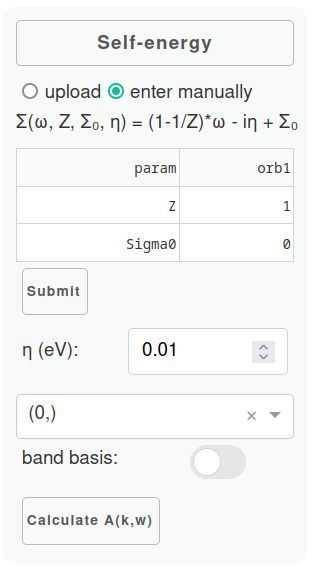

## 7. Advanced: Running a Full charge self-consistent DFT+DMFT calculation

Now that you have mastered the one-shot calculation, you can repeat the calculation with full charge self-consistency and see how the solution changes. Instructions are described in the tutorial:
[flatironinstitute.github.io/solid_dmft/tutorials/Ce2O3_csc_w90/tutorial](https://flatironinstitute.github.io/solid_dmft/tutorials/Ce2O3_csc_w90/tutorial.html)